## Optimal Growth Temperature (OGT): phenotype prediction, feature selection, and data visualization

This notebook provides a pipeline for predicting the optimal growth temperature (OGT) and identifying genome footprints.

We train and test XGBoost regression on COG count tables, that are split into the test and train ones at a specified taxonomy level (i.e. all samples from a taxonomy group go to either train or test). The notebook can be run for one taxonomy level split.

To identify genome footprints and the most important features (COGs) contributing to the phenotype prediction, we use three different feature selection ranking methods:

- calculating the mutual information between the feature and the target label vector,
- using the feature weights returned by the random forest model,
- calculating SHAP values using the pre-trained XGBoost model.

The predictions of those three methods are compared between each other at the end of the notebook.

#### 1. Read the train and test datasets

First, we read the input files generated by *taxa_level_split.py*. The script generates 6 output files for the chosen [tax_level] of the train/test split, that are used as main inputs in this notebook. The files are the following:

- train_data_[tax_level]_tax_level : training count table,
- train_annot_[tax_level]_tax_level : training annotations,
- train_taxa_names_[tax_level]_tax_level : [tax_level] name of each training sample,

\+ 3 similar test tables. Those files should be stored in the corresponding directory for the phenotype.

In order to run the phenotype prediction pipeline in this notebook, the data directory with the input files, and [tax_level] of the train/test split should be specified below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "random" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 2888, number of features = 20
Number of samples = 721, number of features = 20


In [2]:
X_train[0]


tensor([0.0902, 0.0779, 0.0671, 0.0431, 0.0443, 0.1028, 0.0467, 0.0433, 0.0219,
        0.0582, 0.0132, 0.0096, 0.0061, 0.0472, 0.0660, 0.0492, 0.0224, 0.0795,
        0.0401, 0.0712])

In [3]:
# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

Before we train and validate XGBoost on the generated data, we check the distribution of OGTs in the train and test datasets. Ideally, these distributions should be similar and representative (i.e. no missing temperature ranges) to keep both training and validation fair. 

In [2]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())
median_train = np.median(y_train.cpu().squeeze().numpy())

In [4]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 34.427642822265625
Average OGT of the train set = 33.66643524169922


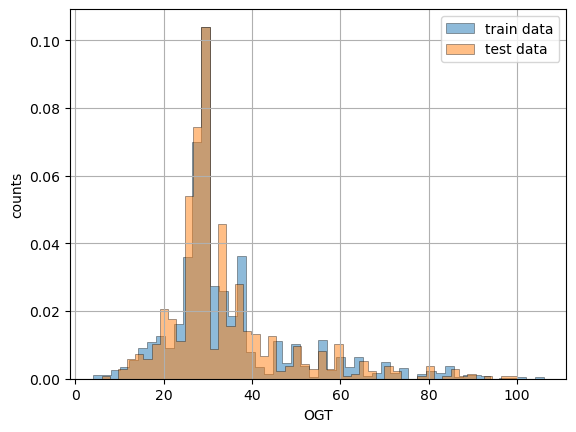

In [5]:
hist = plt.hist(y_train.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();
plt.savefig(f"{OUTPUT_DIRECTORY}/train_test_data_distr.pdf", format="pdf")


#### 2. PCA and tSNE projections of the training data (colors = temperature)

In this section, we visualize all points from our datasets by projecting them into 2D PCA, and tSNE spaces. This projections give us insights on the structure of the datasets. 

First, we visualize the points and color them with respect to their OGTs.

Shape of the projected data = (2888, 2)


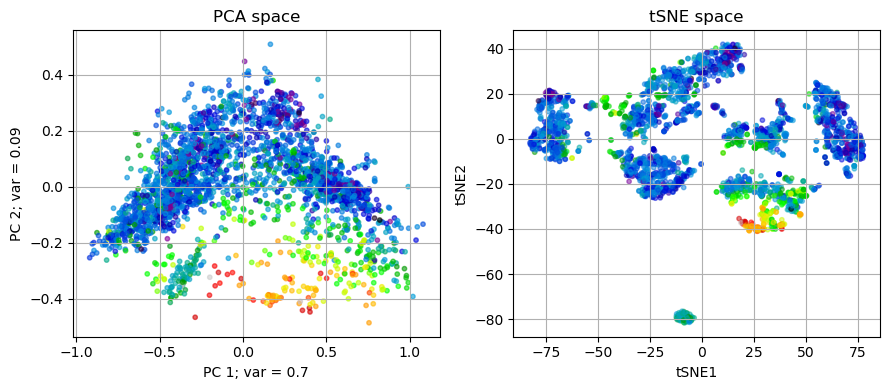

In [6]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_orig_phenot.pdf", format="pdf")
plt.show()

Next, we color the point with respect to the taxonomic level we chose for the train/test data split.

Shape of the projected data = (2521, 2)


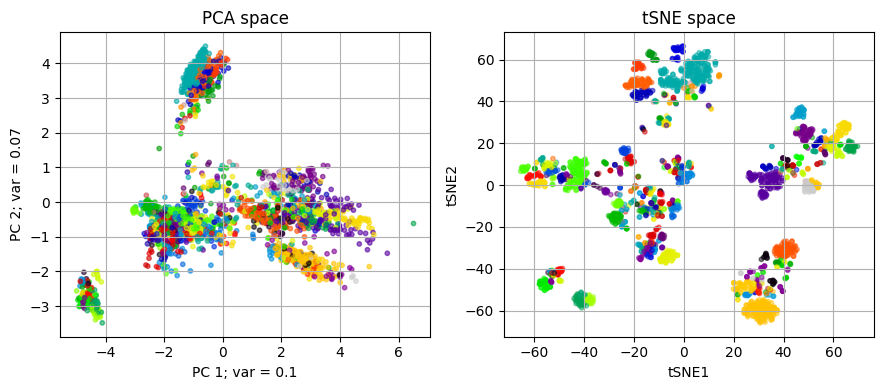

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
colors = None
category_names = taxa_group_names_train
pca_run_and_plot(X_train, n_compon, label_encoder.fit_transform(category_names),
                 category_names, colors);
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, label_encoder.fit_transform(category_names));

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_all_feat.pdf", format="pdf")
plt.show()

#### 3. XGBoost training and feature selection


In this section, we find the baseline XGBoost accuracy measures using the entire initial feature set (e.g. all COGs). For OGT, we use RMSE and R2 calculated for the predicted and actual OGTs.

In [7]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

import numpy as np

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 5.92, R2 = 0.82
XGBoost baseline CV RMSE (all features) = 5.92, R2 = 0.84


The visualisation of the predictions collected during cross-validation and test predictions is shown below. In addition, the discrepancy between the actual and predicted OGTs is shown. As we can see, the lower range temperatures are persistently overestimeted. 

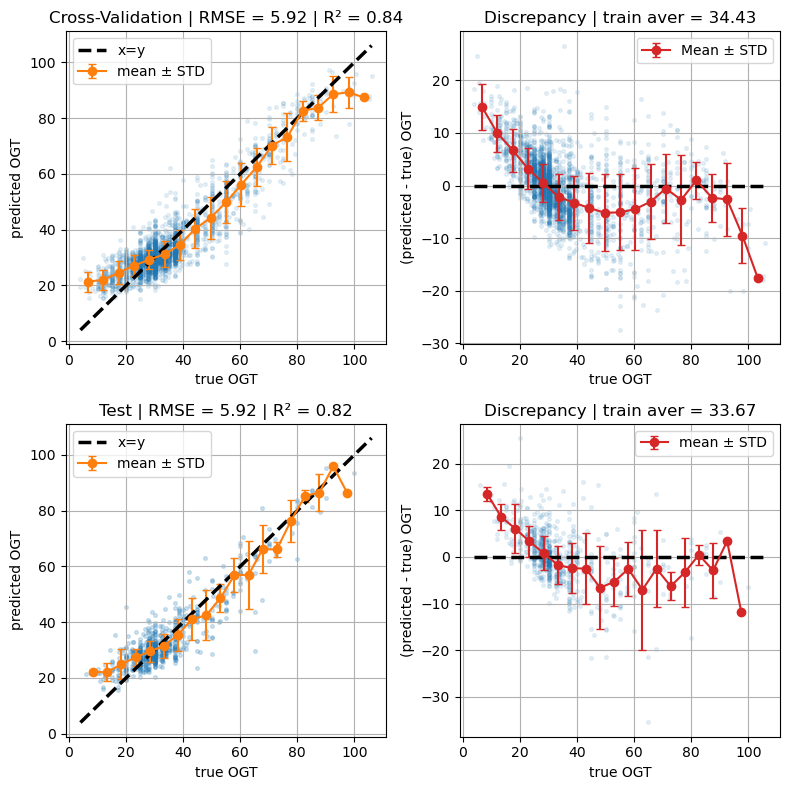

In [8]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

#### 4. SetTransformer training and feature selection


In [9]:
import sys
import os
from pathlib import Path

# Get the current file's directory
current_dir = Path.cwd()

# Add parent and grandparent to sys.path
parent_dir = current_dir.parent
grandparent_dir = parent_dir.parent

sys.path.append(str(parent_dir))
sys.path.append(str(grandparent_dir))

from set_transformer.set_transformer_architecture import SetTransformer

In [10]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

num_folds = 8

from sklearn.model_selection import GroupShuffleSplit

device = DEVICE
ogt_continuous_flag = True
num_epochs = 60
learning_rate = 1e-3

kfold = KFold(n_splits=num_folds, shuffle=True)#, random_state=42)
fold_train_test_ind = enumerate(kfold.split(X_train, y_train))
if ogt_continuous_flag == False:
    dim_output = num_classes
else:
    dim_output = 1    

D = X_train.shape[1]
K = 1

num_inds = 40
batch_size = 20

net = SetTransformer(D, K, dim_output, num_inds)
net = net.to(DEVICE)


In [7]:
target_mean = y_train.mean()
target_std = y_train.std()
weights_np = 3* np.abs((y_train.cpu() - target_mean.cpu()) / target_std.cpu())

1

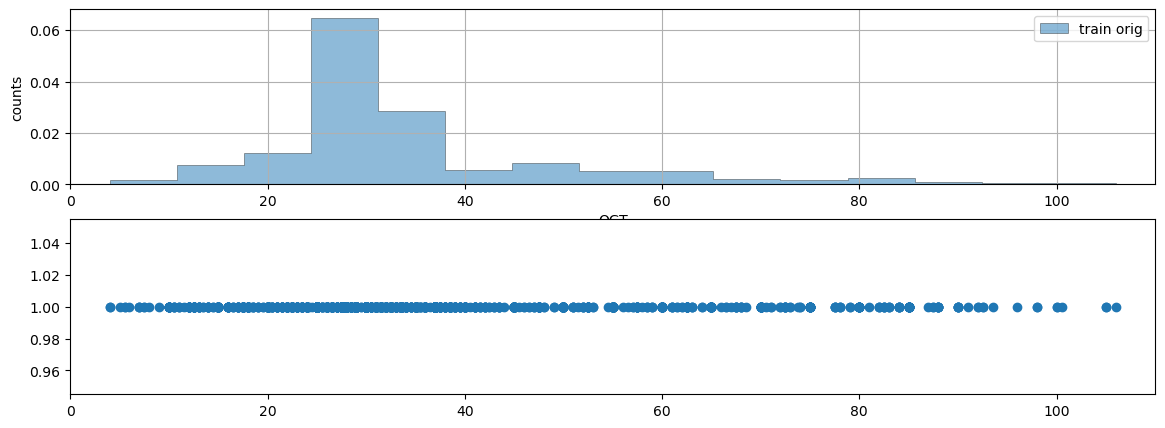

In [14]:
weights = [1]*len(y_train.cpu())


# from scipy.stats import rankdata
# ranks = rankdata(y_train.cpu()) / len(y_train.cpu())
# weights = 1 + np.abs(ranks - 0.5) * 10  # ranges from 1 to 2


# ranks = rankdata(y_train.cpu()) / len(y_train)

# # Initialize weights
# weights = np.ones_like(ranks)

# # Boost left tail (e.g., bottom 10%)
# left_mask = ranks < 0.1
# weights[left_mask] += (0.1 - ranks[left_mask]) * 400  # scale factor

# # Boost right tail (e.g., top 10%)
# right_mask = ranks > 0.6
# weights[right_mask] += (ranks[right_mask] - 0.6) * 200  # stronger boost




# y_np = y_train.squeeze().cpu().numpy()

# # Step 1: Bin the continuous values
# num_bins = 15
# bin_edges = np.linspace(y_np.min(), y_np.max(), num_bins + 1)
# bin_indices = np.digitize(y_np, bins=bin_edges) - 1

# # Step 2: Count samples in each bin
# bin_counts = np.bincount(bin_indices, minlength=num_bins)

# # Step 3: Scale weights between 1 (for max bin count) and 50 (for min bin count)
# min_count = bin_counts.min()
# max_count = bin_counts.max()

# # Avoid division by zero if bins are empty
# bin_counts_safe = bin_counts + 1e-6

# # Normalize so max_count → weight 1, min_count → weight 50
# bin_weights = 1- bin_counts / max_count#(max_count / bin_counts_safe)
# bin_weights = bin_weights / sum(bin_weights)
# bin_weights = 1 + bin_weights*60
# print(bin_counts_safe)
# print(max_count)
# print(bin_weights)
# #bin_weights = 1 + (bin_weights - 1) * (5 - 1) / (bin_weights.max() - 1)

# # Step 4: Assign sample weights
# weights = bin_weights[bin_indices]

# # Optional: Normalize to mean 1 (helps keep training stable)
# weights /= weights.mean()



plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1) 
hist = plt.hist(y_train.cpu(), bins =15, density = True, label = "train orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.xlim([0, 110])
plt.legend();

plt.subplot(2, 1, 2) 
plt.scatter(y_train.cpu(), weights)
plt.xlim([0, 110])
min(weights)
#bin_counts





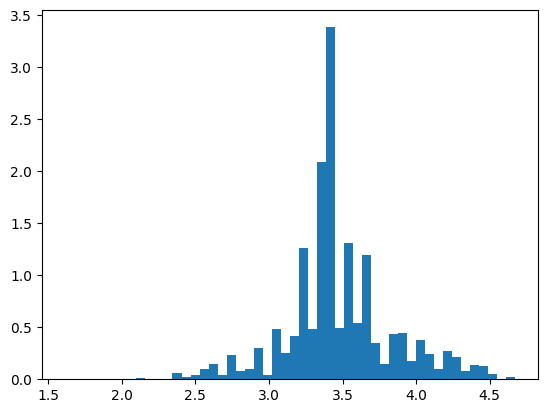

In [11]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
y_trans = pt.fit_transform(y_train.cpu().reshape(-1, 1))

import numpy as np
y_train_transformed = np.log1p(y_train.cpu()) 
y_test_transformed = np.log1p(y_test.cpu()) 

plt.hist(y_train_transformed, density=True, bins = 50);
#plt.hist(y_train, density=True, bins = 80);

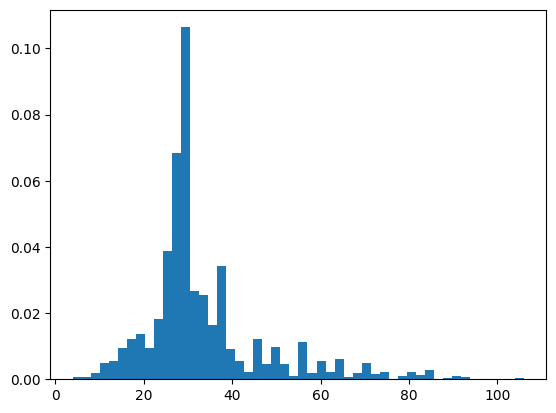

In [13]:
plt.hist(y_train.cpu(), density=True, bins = 50);

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.optim as optim
import numpy as np

def quantile_loss(y_pred, y_true, q=0.8):
    error = y_true - y_pred
    return torch.max(q * error, (q - 1) * error).mean()

def train_set_transformer(X_train, y_train, X_test, y_test, weights, num_classes, num_inds=num_inds, ogt_continuous_flag=False, num_epochs=num_epochs, batch_size=batch_size):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    D = X_train.shape[1]
    K = 1
    dim_output = 1 if ogt_continuous_flag else num_classes

    lr = 1e-3

    def create_model():
        net = SetTransformer(D, K, dim_output, num_inds)
        return net.to(device)

    num_folds = 5

    kf = KFold(n_splits=num_folds, shuffle=True)
    y_true_list = []
    y_pred_list = []

    weights_tensor_all = torch.tensor(weights, dtype=torch.float32).to(device)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        print(f"\nFold {fold+1}/{num_folds}")
        model = create_model()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        criterion = torch.nn.MSELoss(reduction='none') if ogt_continuous_flag else torch.nn.CrossEntropyLoss()

        # Prepare data
        X_fold_train = torch.tensor(X_train[train_idx], dtype=torch.float32).to(device)
        y_fold_train = torch.tensor(y_train[train_idx], dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)
        X_fold_val = torch.tensor(X_train[val_idx], dtype=torch.float32).to(device)
        y_fold_val = torch.tensor(y_train[val_idx], dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)

        weights_fold_train = weights_tensor_all[train_idx].to(device)

       # train_loader = DataLoader(TensorDataset(X_fold_train, y_fold_train), batch_size=batch_size, shuffle=True)

        train_dataset = TensorDataset(X_fold_train, y_fold_train, torch.arange(len(y_fold_train)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        
        # Training loop
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_data, batch_labels, batch_indices in train_loader:
            #for batch_data, batch_labels in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_data.unsqueeze(1)).squeeze()
                if ogt_continuous_flag and outputs.ndim == 1:
                    outputs = outputs.unsqueeze(1)

                loss_raw = criterion(outputs, batch_labels) #criterion(outputs, batch_labels) #
                batch_weights = weights_fold_train[batch_indices]
                loss = (loss_raw.squeeze() * batch_weights).mean()

                # plt.figure(figsize=(14, 7))
                # plt.scatter(batch_labels.cpu(), batch_weights.cpu())
                # plt.show()

              #  print(f"batch_labels = {batch_labels}; batch_weights = {batch_weights}")
             #   print(f"loss_raw.squeeze() = {loss_raw.squeeze()}; loss = {loss}")

                
              #  loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"CV epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_fold_val.unsqueeze(1)).squeeze()
            if not ogt_continuous_flag:
                preds = torch.nn.functional.softmax(preds, dim=-1)
                pred_classes = torch.argmax(preds, dim=1)
                y_true_list.append(y_fold_val.cpu().numpy())
                y_pred_list.append(pred_classes.cpu().numpy())
            else:
                y_true_list.append(y_fold_val.cpu().numpy())
                y_pred_list.append(preds.cpu().numpy())

    y_true_cv = np.concatenate(y_true_list)
    y_pred_cv = np.concatenate(y_pred_list)

    # Final training on full train set
    model = create_model()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = torch.nn.MSELoss() if ogt_continuous_flag else torch.nn.CrossEntropyLoss()

    X_full_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_full_train = torch.tensor(y_train, dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)

    full_dataset = TensorDataset(X_full_train, y_full_train, torch.arange(len(y_full_train)))
    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)
    #full_loader = DataLoader(TensorDataset(X_full_train, y_full_train), batch_size=batch_size, shuffle=True)

    model.train()

    # In training:
  #  weights = np.abs((y_train - y_train.mean()) / y_train.std())
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_data, batch_labels, batch_indices in full_loader:
            #print(f"batch_labels = {batch_labels}")
            optimizer.zero_grad()
            outputs = model(batch_data.unsqueeze(1)).squeeze()
            if ogt_continuous_flag and outputs.ndim == 1:
                outputs = outputs.unsqueeze(1)

            loss_raw = criterion(outputs, batch_labels)  # quantile_loss(outputs, batch_labels)#
            batch_weights = weights_tensor[batch_indices]
            loss = (loss_raw.squeeze() * batch_weights).mean()

            # plt.figure(figsize=(14, 7))
            # plt.scatter(batch_labels.cpu(), batch_weights.cpu())
            # plt.show()
            
           # loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Training epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Final prediction
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        test_outputs = model(X_test_tensor.unsqueeze(1)).squeeze()
        if not ogt_continuous_flag:
            test_outputs = torch.nn.functional.softmax(test_outputs, dim=-1)
            y_pred_test = torch.argmax(test_outputs, dim=1).cpu().numpy()
        else:
            y_pred_test = test_outputs.cpu().numpy()

    return y_true_cv, y_pred_cv, y_pred_test


In [16]:
target_mean = np.mean(y_train.squeeze().cpu().numpy())
target_mean

34.427643

In [17]:
num_classes=20
y_true_cv, y_pred_cv, y_pred_test = train_set_transformer(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights, num_classes, num_inds, ogt_continuous_flag=ogt_continuous_flag, num_epochs=num_epochs, batch_size=batch_size)




Fold 1/5


/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_15695/3032531843.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_fold_train = torch.tensor(X_train[train_idx], dtype=torch.float32).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_15695/3032531843.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_fold_train = torch.tensor(y_train[train_idx], dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_15695/3032531843.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

CV epoch 1/60, Loss: 410.5461
CV epoch 2/60, Loss: 226.6046
CV epoch 3/60, Loss: 221.7528
CV epoch 4/60, Loss: 219.6809
CV epoch 5/60, Loss: 212.8886
CV epoch 6/60, Loss: 173.1464
CV epoch 7/60, Loss: 165.7775
CV epoch 8/60, Loss: 189.7354
CV epoch 9/60, Loss: 106.9096
CV epoch 10/60, Loss: 81.8853
CV epoch 11/60, Loss: 87.5091
CV epoch 12/60, Loss: 72.2123
CV epoch 13/60, Loss: 72.9906
CV epoch 14/60, Loss: 70.5252
CV epoch 15/60, Loss: 64.6001
CV epoch 16/60, Loss: 68.6965
CV epoch 17/60, Loss: 64.7084
CV epoch 18/60, Loss: 57.3949
CV epoch 19/60, Loss: 58.2361
CV epoch 20/60, Loss: 59.6924
CV epoch 21/60, Loss: 58.1220
CV epoch 22/60, Loss: 66.7593
CV epoch 23/60, Loss: 56.4201
CV epoch 24/60, Loss: 54.5315
CV epoch 25/60, Loss: 54.0269
CV epoch 26/60, Loss: 53.0805
CV epoch 27/60, Loss: 51.5848
CV epoch 28/60, Loss: 50.1796
CV epoch 29/60, Loss: 48.8066
CV epoch 30/60, Loss: 51.3705
CV epoch 31/60, Loss: 48.7864
CV epoch 32/60, Loss: 52.2153
CV epoch 33/60, Loss: 46.5236
CV epoch 3

/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_15695/3032531843.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_full_train = torch.tensor(X_train, dtype=torch.float32).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_15695/3032531843.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_full_train = torch.tensor(y_train, dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)


Training epoch 1/60, Loss: 477.4747
Training epoch 2/60, Loss: 290.5939
Training epoch 3/60, Loss: 290.1626
Training epoch 4/60, Loss: 288.5367
Training epoch 5/60, Loss: 274.2445
Training epoch 6/60, Loss: 197.8822
Training epoch 7/60, Loss: 132.8927
Training epoch 8/60, Loss: 113.8567
Training epoch 9/60, Loss: 100.2927
Training epoch 10/60, Loss: 86.1706
Training epoch 11/60, Loss: 91.4431
Training epoch 12/60, Loss: 79.5489
Training epoch 13/60, Loss: 84.1219
Training epoch 14/60, Loss: 74.7869
Training epoch 15/60, Loss: 76.8943
Training epoch 16/60, Loss: 74.3766
Training epoch 17/60, Loss: 84.6456
Training epoch 18/60, Loss: 75.0593
Training epoch 19/60, Loss: 74.3166
Training epoch 20/60, Loss: 73.1660
Training epoch 21/60, Loss: 67.9493
Training epoch 22/60, Loss: 62.3560
Training epoch 23/60, Loss: 61.7845
Training epoch 24/60, Loss: 69.9334
Training epoch 25/60, Loss: 65.6428
Training epoch 26/60, Loss: 68.3785
Training epoch 27/60, Loss: 65.3100
Training epoch 28/60, Loss: 

/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_15695/3032531843.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


In [17]:
y_true_cv = np.expm1(y_true_cv)
y_pred_cv = np.expm1(y_pred_cv)
y_pred_test = np.expm1(y_pred_test)

# y_train = y_train_transformed
# y_test = y_test_transformed

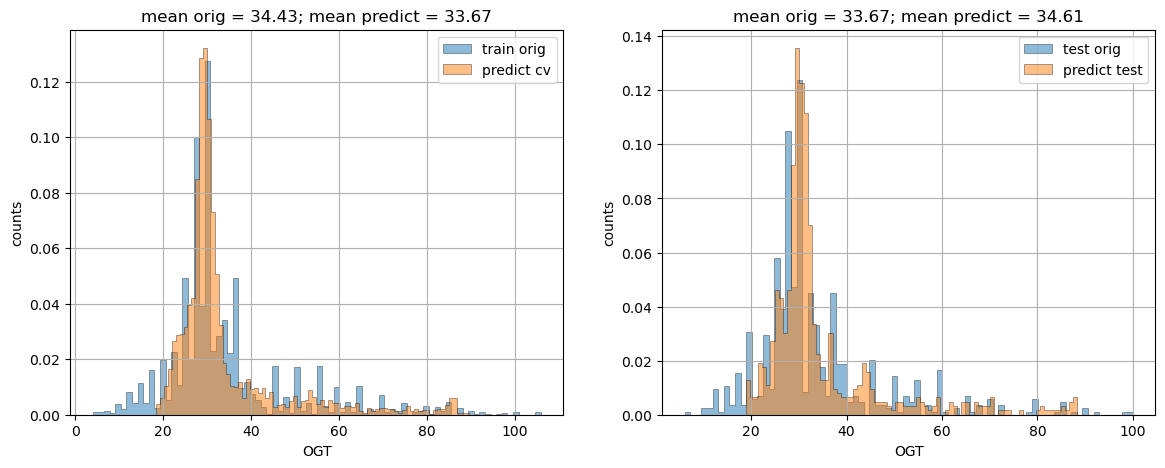

In [19]:
plt.figure(figsize=(14, 5))
y_test = y_test.cpu()
plt.subplot(1, 2, 1) 
hist = plt.hist(y_train.cpu(), bins = 80, density = True, label = "train orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_pred_cv, bins = 80, density = True, label = "predict cv", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.title(f"mean orig = {np.mean(y_train.cpu().squeeze().numpy()):.2f}; mean predict = {np.mean(y_test.cpu().squeeze().numpy()):.2f}")
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

plt.subplot(1, 2, 2) 
hist = plt.hist(y_test.cpu(), bins = 80, density = True, label = "test orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_pred_test, bins = 80, density = True, label = "predict test", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.title(f"mean orig = {np.mean(y_test.cpu().squeeze().numpy()):.2f}; mean predict = {np.mean(y_pred_test):.2f}")
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

In [20]:
from sklearn.metrics import mean_squared_error,r2_score
rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 5.91, R2 = 0.82
XGBoost baseline CV RMSE (all features) = 6.41, R2 = 0.82


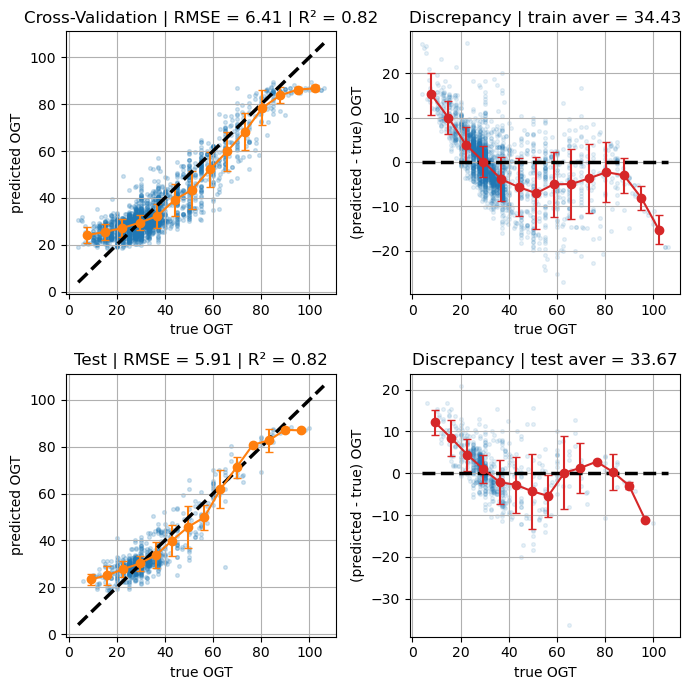

In [21]:
from utils.utils import calculate_aver_std

plt.figure(figsize=(7, 7))

num_bins = 15
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 4) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

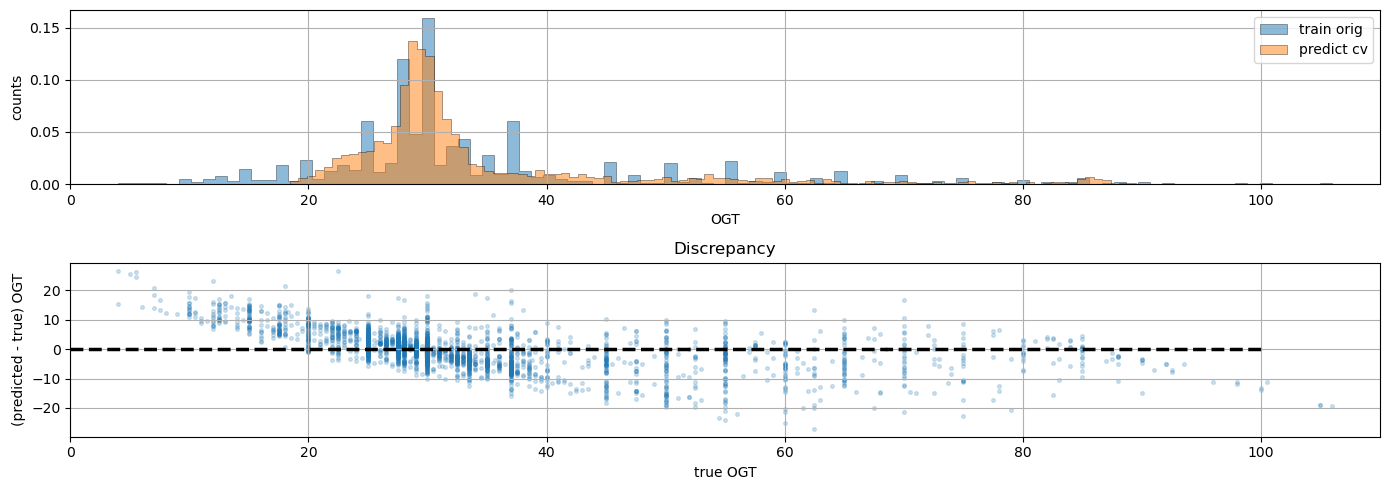

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1) 
hist = plt.hist(y_train.cpu(), bins = 100, density = True, label = "train orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_pred_cv, bins = 100, density = True, label = "predict cv", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.xlim([0, 110])
plt.grid(True)
plt.legend();

plt.subplot(2, 1, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.xlim([0, 110])
plt.grid(True)

plt.tight_layout()  


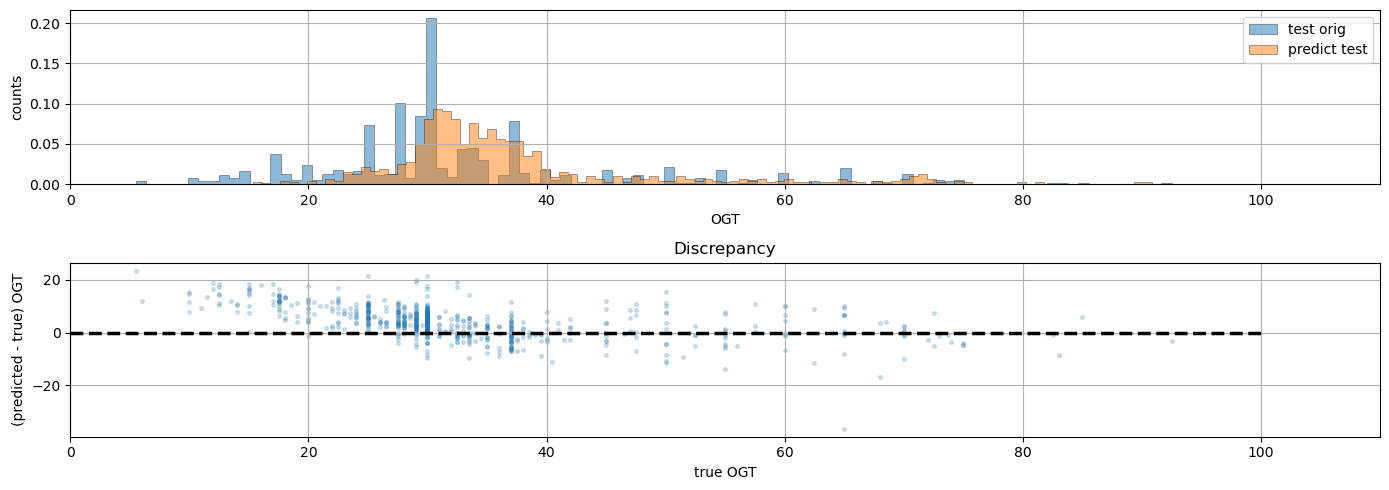

In [135]:
plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1) 
hist = plt.hist(y_test.cpu(), bins = 100, density = True, label = "test orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_pred_test, bins = 100, density = True, label = "predict test", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlim([0, 110])
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

plt.subplot(2, 1, 2) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlim([0, 110])
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)
plt.tight_layout()  



Shape of the projected data = (2888, 2)


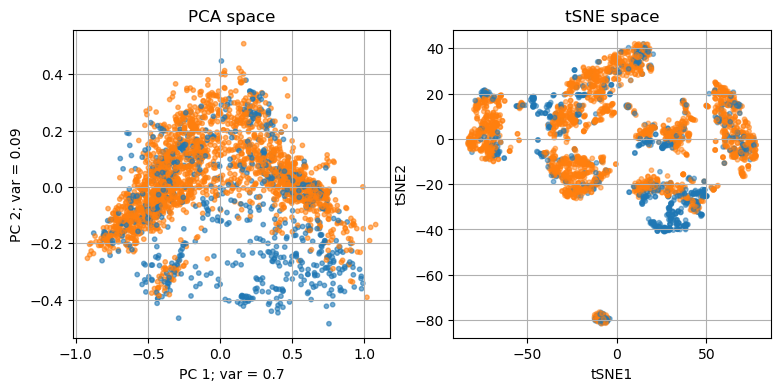

In [24]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [5 if yi>20 and yi<45  else 0 for yi in y_train]

colors = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train_masked, None, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train_masked, colors);

### 2. Feature selection

#### 2.1. Feature space

In [ ]:
X_train_np = np.array(X_train)
X_train_transposed = X_train_np.T
print(f"X_train_transposed shape = {X_train_transposed.shape}")

Next, we perform feature selection. First, we rank all the features with respect to the chosen method (mutual information, random forest weigths, and SHAP) from the most to the least importan ones. Then we gradually add ranked features starting from the most important one, re-train the model and evaluate its performance. As the second test, we gradually remove features satrting from the least important ones, and evaluate the performance of the re-trained model again. The results are shown below.

As a baseline, we do this analysis for random feature ranking, i.e. we generate random feature order N times, and find the average accuracy and std across the runs for the added and removed features.

In [ ]:
from utils.utils import random_feat_removal_curves_ogt
num_runs = 5
feat_step = 20

feat_removal = False
rmse_test_arr_mean_add, rmse_test_arr_std_add, r2_test_arr_mean_add, r2_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add = random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal)

In [ ]:
feat_removal = True
rmse_test_arr_mean_rem, rmse_test_arr_std_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem  = random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal)

#### 3.1 Feature selection with Mutual Information

In this section, we rank the features (COGs) using the mutual information. The mutual information quantifies "the amount of information one random variable contains about another".

We calculate the mutual information between each feature and the target label vector with phenotypes, and rank all the features from the largest to the smallest value.

In [11]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train, y_train.squeeze(), X_column_names, RANDOM_SEED, contin_flag = True)

In [12]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(len(top_feat_mi_counts[0]))

print(f"Top {N} COGs:", top_N_names_by_mi)

2276
Top 30 COGs: ['K03296', 'K03286', 'K06158', 'K07277', 'K02199', 'K09458', 'K03654', 'K08234', 'K00537', 'K03088', 'K03559', 'K15977', 'K03832', 'K10804', 'K00831', 'K03321', 'K07305', 'K01142', 'K07735', 'K05807', 'K03797', 'K06911', 'K12340', 'K09808', 'K03704', 'K01256', 'K04744', 'K02078', 'K07107', 'K02355']


Using the ranked features, we re-generate the PCA and tSNE projections using the top N features only. It's expected that the separation between diffetent classes become more prominent.

Shape of the projected data = (2276, 2)


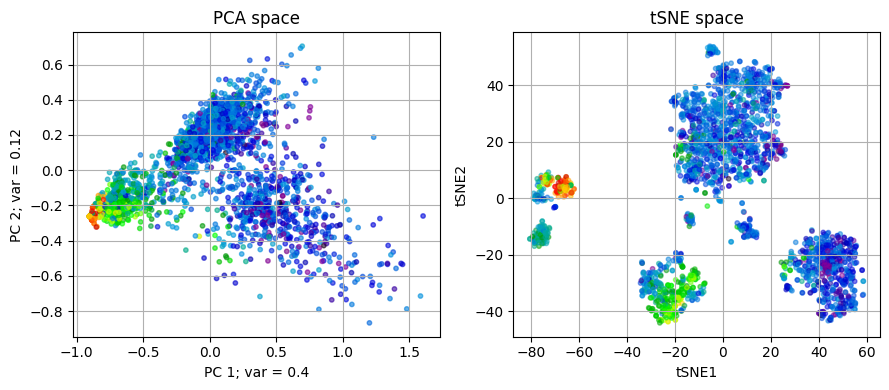

In [13]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_mi_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_mi_counts).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_top{N}_mi_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 20
feat_removal = False
rmse_test_arr_mi_add, r2_test_arr_mi_add, rmse_cv_arr_mi_add, r2_cv_arr_mi_add, num_feat_plot = xgboost_accuracy_contin(X_train.cpu(), X_test.cpu(), y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_mi_add, rmse_cv_arr_mi_add, rmse_test_arr_mean_add, rmse_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, num_feat_plot)
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features added")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_mi_add, r2_cv_arr_mi_add, r2_test_arr_mean_add, r2_test_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add, num_feat_plot)
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features added")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf") 

In [ ]:
feat_removal = True
rmse_test_arr_mi_rem, r2_test_arr_mi_rem, rmse_cv_arr_mi_rem, r2_cv_arr_mi_rem, num_feat_plot_rem = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_mi_rem, rmse_cv_arr_mi_rem, rmse_test_arr_mean_rem, rmse_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features kept after removing")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_mi_rem, r2_cv_arr_mi_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features kept after removing")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top MI features") 
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(hspace=0.4) 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf") 


#### 3.2 Feature selection with Random Forest

In this section, we rank the features (COGs) using random forest model. During training, the model assigns weights to each feature with respect to their importamce to the prediction task. We train random forest on the train dataset, find the weights, and rank the features with respect to the values of the weights.

The rest of the analysis is the same as the one for the mutual information.

In [ ]:
from feature_selection.feature_selection_utils import random_forest_features

sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_train, y_train, X_column_names, RANDOM_SEED, contin_flag = True)

In [ ]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

In [ ]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_forest_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_forest_counts).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 20
feat_removal = False
rmse_test_arr_randfor, r2_test_arr_randfor, rmse_cv_arr_randfor, r2_cv_arr_randfor, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_randfor, rmse_cv_arr_randfor, rmse_test_arr_mean_add, rmse_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, num_feat_plot)
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features added")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_randfor, r2_cv_arr_randfor, r2_test_arr_mean_add, r2_test_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add, num_feat_plot)
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features added")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_rand_forest_feat_add.pdf", format="pdf") 

In [ ]:
feat_removal = True
rmse_test_arr_randfor_rem, r2_test_arr_randfor_rem, rmse_cv_arr_randfor_rem, r2_cv_arr_randfor_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_randfor_rem, rmse_cv_arr_randfor_rem, rmse_test_arr_mean_rem, rmse_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features kept after removing")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_randfor_rem, r2_cv_arr_randfor_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features kept after removing")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top RandomForest features") 
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(hspace=0.4) 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_rand_forest_feat_remov.pdf", format="pdf") 

#### 3.3 Feature selection with SHAP values

In this section, we rank the features (COGs) with respect to their SHAP values. SHAP value for a feature is calculated by re-training a model without this feature and comparing the accuracy to the original one on the full feature set. We calculate SHAP values for all features, and rank them from the largest to the smallest.

The rest of the analysis is the same as the ones in the two previous cases.

In [ ]:
from feature_selection.feature_selection_utils import shap_features

contin_flag = True
sorted_cog_idx_by_shap, sorted_importances, sorted_names = shap_features(X_train, y_train, X_column_names, DEVICE, contin_flag)

In [ ]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_rand_shap = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]
print(f"Top {N} COGs:", top_N_names_by_shap)

In [ ]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_shap).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_shap).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 20
feat_removal = False
rmse_test_arr_shap, r2_test_arr_shap, rmse_cv_arr_shap, r2_cv_arr_shap, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_shap, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_shap, rmse_cv_arr_shap, rmse_test_arr_mean_add, rmse_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, num_feat_plot)
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features added")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_shap, r2_cv_arr_shap, r2_test_arr_mean_add, r2_test_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add, num_feat_plot)
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features added")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_add.pdf", format="pdf") 

In [ ]:
feat_removal = True
rmse_test_arr_shap_rem, r2_test_arr_shap_rem, rmse_cv_arr_shap_rem, r2_cv_arr_shap_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_shap, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_shap_rem, rmse_cv_arr_shap_rem, rmse_test_arr_mean_rem, rmse_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features kept after removing")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_shap_rem, r2_cv_arr_shap_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features kept after removing")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top SHAP features") 
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(hspace=0.4) 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_remov.pdf", format="pdf") 

#### 4. Feature comparison

In this section, we compare top of the most important features predicted with mutual information, random forest, and SHAP values between each other. The lists of the top N features should overlap..

In [ ]:
import pandas as pd

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

Also, we construct a correlation matrix wetween the top features returned by each method.

In [ ]:
plt.figure(figsize=(15, 3))

vmin, vmax = -1, 1 #-0.6
device = DEVICE
# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RANDOM Forest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_rand_shap)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")

#### 5. Expression level of the top features

In this section, we visualize the expression level of a feature in the train samples (with respect to the feature counts). Comparison of this plot to the PCA/tSNE projections with points colored with respect to their phenotype can give insights on the feature "signal distribution" across the samples and the different phenotype groups.

In [27]:
feature_name = 'K07464'  #X_train, y_train, X_column_names, taxa_group_names_train
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_train[:, idx]
feature_expression = feature_expression.cpu()

Shape of the projected data = (2513, 2)


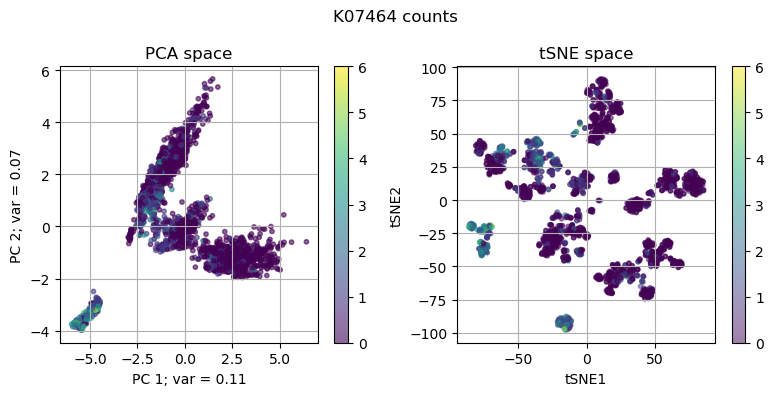

In [28]:
from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
category_names = ["anaerobe" if yi == 0 else "aerobe" for yi in y_train]
pca_run_and_plot(X_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train.cpu(), 30, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"{feature_name} counts")

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_{feature_name}_express_lev.pdf", format="pdf")
plt.show()

In [ ]:
# Number of selected features to add/remove from the list of top features
N = 3000
ogt_continuous_flag = True
precence_only_flag = False

plt.figure(figsize=(12.5, 12.5))

# MI top features signal
select_feat_mi = list(sorted_cog_idx_by_mi[:N])
X_train_select_feat = X_train[:, select_feat_mi]
X_test_select_feat = X_test[:, select_feat_mi]

select_feat_mi_rem = list(sorted_cog_idx_by_mi[N:])
X_train_select_feat_rem = X_train[:, select_feat_mi_rem]
X_test_select_feat_rem = X_test[:, select_feat_mi_rem]

# 1: MI top N predict
plt.subplot(4, 4, 1) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 5: Diff for MI top N predict
plt.subplot(4, 4, 5) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 9: MI top N predict: test
plt.subplot(4, 4, 9) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 13: Diff for MI top N predict
plt.subplot(4, 4, 13) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 2: MI w/o top N predict
plt.subplot(4, 4, 2) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 6: Diff for MI w/o top N predict
plt.subplot(4, 4, 6) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 10: MI w/o N predict: test
plt.subplot(4, 4, 10) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 14: Diff for MI top N predict
plt.subplot(4, 4, 14) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# RandomForest only signal
select_feat_ranfor = list(sorted_cog_idx_by_rand_forest[:N])
X_train_select_feat = X_train[:, select_feat_ranfor]
X_test_select_feat = X_test[:, select_feat_ranfor]

select_feat_ranfor_rem = list(sorted_cog_idx_by_rand_forest[N:])
X_train_select_feat_rem = X_train[:, select_feat_ranfor_rem]
X_test_select_feat_rem = X_test[:, select_feat_ranfor_rem]

#3: RandomForest top N predict
plt.subplot(4, 4, 3) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#7: Diff RandomForest top N predict
plt.subplot(4, 4, 7) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 11: RandomForest top N predict: test
plt.subplot(4, 4, 11) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 15: Diff for RandomForest top N predict
plt.subplot(4, 4, 15) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

#4: RandomForest w/o top N predict
plt.subplot(4, 4, 4) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#8: Diff RandomForest w/o top N predict
plt.subplot(4, 4, 8) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 12: RandomForest top N predict: test
plt.subplot(4, 4, 12) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 16: Diff for RandomForest w/o top N predict
plt.subplot(4, 4, 16) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='^', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

num_coinc = len(set(select_feat_mi) & set(select_feat_ranfor))
print(f"Number of coinciding COGs =  {num_coinc}, which is {round(100*num_coinc/N,2)}%")

plt.savefig(f"{OUTPUT_DIRECTORY}/examples_top{N}_feat.pdf", format="pdf")